In [110]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.special import logsumexp
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import geometry
import itertools
from collections import defaultdict
import collections
import target
import controler
import utils
from functools import reduce
import linear_regression
from multiprocessing import Pool
from functools import partial
import numpy as np
import geometry
import itertools 
from itertools import islice
import games

def eval_ucb1_parallel(task, nbCores, n_folds, horizon, method):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    return np.asarray(  pool.map( partial( task.ucb1, method ), range(n_folds) ) ) 

def eval_feedexp_parallel(task, nbCores, n_folds, horizon, general_algo, method):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    return np.asarray(  pool.map( partial( task.feedexp3, general_algo, method ), range(n_folds) ) ) 

def eval_cpbvanilla_parallel(task, nbCores, n_folds, horizon, alpha):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    return np.asarray(  pool.map( partial( task.cpb_vanilla_v2 ,alpha ), range(n_folds) ) ) 

def runif_in_simplex(n):
  ''' Return uniformly random vector in the n-simplex '''

  k = np.random.exponential(scale=1.0, size=n)
  return k / sum(k)

class SyntheticCase:

    def __init__(self, LossMatrix, FeedbackMatrix, horizon ):
 
        self.LossMatrix = LossMatrix 
        self.FeedbackMatrix = FeedbackMatrix 
        

        self.horizon = horizon
        self.n_actions = len(self.LossMatrix)

    def set_outcomes(self, LossMatrix, job_id):
        #np.random.seed(job_id)
        self.means = runif_in_simplex( len( LossMatrix[0] ) )
        self.outcomes = np.random.choice( len( LossMatrix[0] ) , p=[0.6, 0.4], size= self.horizon) # [0.05, 0.95]

    def get_feedback(self, FeedbackMatrix, action, outcome):
        return FeedbackMatrix[ action ][ outcome ] 


    def ucb1(self, method, job_id):
        '''Play the given bandit over T rounds using the UCB1 strategy.'''

        self.set_outcomes(job_id)

        regret = []
        
        sum_estimators = [0] * self.n_actions
        counters = [0] * self.n_actions
        
        k_star = np.argmax(self.means)
        gaps = self.means[k_star] - self.means
        
        for t in range(self.horizon):
            outcome = self.outcomes[t]
            
            error_pbt = 1 / (self.horizon**2)
            
            UCB =  [ sum_estimators[k]  / counters[k] + np.sqrt(  2 * np.log( 1 / error_pbt ) / counters[k] ) if counters[k] !=0 else np.inf for k in range(self.n_actions) ] 
            # print(  [ sum_estimators[k]  / counters[k]  if counters[k] !=0 else np.inf for k in range(self.n_actions) ]  )
            action = np.argmax( UCB )
            reward =  self.get_feedback(action, outcome)
            counters[action] = counters[action] + 1
            sum_estimators[action] =   sum_estimators[action] + reward

            # policy suffers loss and regret
            regret.append( gaps[action ]  )

        return np.array(regret)


    # def W(self, mathcal_N, N_bar, observer_vector ):
    #     W = np.zeros( len(N_bar) )
    #     for pair in mathcal_N:
    #         for k in N_bar:
    #             value = np.fabs( observer_vector[ pair[0] ][ pair[1] ][k] ).max()
    #             W[k] = max( W[k], value  )
    #     return W

    # def cpb_vanilla_v2(self,alpha, job_id):
    #     np.random.seed(job_id)
    #     regret = []

    #     self.set_outcomes(job_id)

    #     N_bar = [0,1]
    #     M_bar = [0,1]
    #     e = np.eye(2)
        
    #     N = len(self.LossMatrix )
    #     n = np.zeros(N)
    #     v = [  np.zeros( len(set(i)) ) for i in self.FeedbackMatrix ] 
    #     mathcal_P = [ a for a in N_bar if geometry.isParetoOptimal(1, self.LossMatrix )] # set of pareto optimal actions
    #     mathcal_N = [ pair for pair in list( itertools.combinations([0,1], 2) ) if geometry.areNeighbours(pair[0], pair[1], self.LossMatrix ) ] #set of unordered neighboring actions
    #     # print(mathcal_N)
    #     #mathcal_N_plus = [ geometry.get_neighborhood_action_set(pair, N_bar, L) for pair in mathcal_N]  #neighborhood action set of pair 
    #     mathcal_N_plus = collections.defaultdict(dict)
    #     for pair in mathcal_N:
    #             mathcal_N_plus[ pair[0] ][ pair[1] ] = geometry.get_neighborhood_action_set(pair, N_bar, self.LossMatrix )

    #     observer_set = collections.defaultdict(dict)
    #     for pair in mathcal_N : 
    #             if geometry.ObservablePair(pair[0], pair[1], self.LossMatrix, [geometry.signal_vecs(i, self.FeedbackMatrix) for i in geometry.Neighbourhood(0, 1, self.LossMatrix )]):
    #                     observer_set [ pair[0] ][ pair[1] ] =   mathcal_N_plus[ pair[0] ][ pair[1] ] 
    #             else:
    #                     observer_set [ pair[0] ][ pair[1] ] = None
    #                     print('Observer set -- not implemented')

    #     observer_vector = collections.defaultdict(dict)
    #     for pair in mathcal_N :
    #             observer_vector[ pair[0] ][ pair[1] ] = geometry.get_observer_vector( pair ,self.LossMatrix ,self.FeedbackMatrix,observer_set) 

    #     W = self.W( mathcal_N, N_bar, observer_vector )

    #     # print('mathcal P', mathcal_P)
    #     # print('mathcal N', mathcal_N)

    #     for t in range(self.horizon):

    #         if t < N:  # initialisation
    #             action  = t
    #             outcome = self.outcomes[t]
    #             Y = geometry.signal_vecs(action, self.FeedbackMatrix) @ e[outcome]
    #             n[action] += 1
    #             v[action] += Y

    #             regret.append( self.gaps[action ]  )

    #         else: 
    #             break
                
    #     for t in range(self.horizon):
    #         outcome = self.outcomes[t]
    #         half_space = collections.defaultdict(dict)

    #         if t >= N:

    #             for pair in mathcal_N:
    #                 # print( 'inside', [  observer_vector[ pair[0] ][ pair[1] ][k].T * v[k]/n[k]   for k in mathcal_N_plus ] )
    #                 d_ij = sum( [  observer_vector[ pair[0] ][ pair[1] ][k].T @ v[k]/n[k]   for k in mathcal_N_plus ] )
    #                 c_ij = sum( [  np.fabs(  observer_vector[ pair[0] ][ pair[1] ][k] ).max()  * np.sqrt(alpha * np.log(t) / n[k] )    for k in mathcal_N_plus ] )
    #                 # print('d_ij',d_ij)
                    
    #                 if abs( d_ij ) >= c_ij:
    #                     half_space[ pair[0] ][ pair[1] ] = np.sign(d_ij)
    #                 else:
    #                     half_space[ pair[0] ][ pair[1] ] = 0

    #             #print('halfspace', half_space)

    #             #print('P before:',mathcal_P)
    #             mathcal_P = geometry.get_P_t(half_space, self.LossMatrix, mathcal_P, mathcal_N)
    #             #print('P after:',mathcal_P)

    #             #print('N before:',mathcal_N)
    #             mathcal_N = geometry.get_N_t(half_space, self.LossMatrix, mathcal_P, mathcal_N)
    #             #print('N after:',mathcal_N)

    #             #print()

    #             Q = reduce( np.union1d, [ mathcal_N_plus[ pair[0] ][ pair[1] ]  for pair in mathcal_N ]  )
    #             values = [ W[k]/n[k] for k in Q ]
    #             # print('values', values)
                
    #             action = np.argmax(values)
    #             Y = geometry.signal_vecs(action, self.FeedbackMatrix) @ e[outcome]
    #             n[action] += 1
    #             v[action] += Y

    #             regret.append( self.gaps[action ]  )

    #     return np.array(regret)


    def parameters_Bianchi(self, C, t):
        # [Bianchi et al. 2006 "Regret minimization under partial monitoring"]
        if t == 1: 
            eta = 1 / C * pow( np.log( self.n_actions ) / ( self.n_actions * t ) , 2./3.) 
            gamma = min(1,  C * pow( ( np.log( self.n_actions ) * self.n_actions **2) / t , 1./3.) )
        else: 
            eta = 1 / C * pow( np.log( self.n_actions ) / ( self.n_actions * t ) , 2./3.) 
            gamma = C * pow( ( np.log( self.n_actions ) * self.n_actions **2) / t , 1./3.)
        return eta, gamma 

    def parameters_Piccolboni(self, ):
        ## [Piccolboni Schindelhauer "Discrete Prediction Games with Arbitrary Feedback and Loss" 2000]
        ## fixed-known-horizon setting
        eta = pow( np.log(self.n_actions), 1./2.) / pow(self.horizon, 1./2.)
        gamma = np.fmin(1., pow(self.n_actions, 1./2.) * pow( np.log(self.n_actions),1./4.) / pow(self.horizon, 1./4.))
        return eta, gamma


    def general_algorithm(self, F, L):
        # print(F)

        N, M = F.shape

        Fdash_list = []
        Ldash_list = []
        # We use the lists sizes for z in paper
        h = {} # pseudo-action to action map
        s = {} # pseudo-action to symbol map

        for j in range(self.n_actions):

            for v in set(F[j,...]):
                
                Fiv = geometry.signal_vec( j, v, F )

                if not Fdash_list or not geometry.is_linear_comb(Fiv, Fdash_list):
                    h[len(Fdash_list)] = j # h(z)=i in FeedExp3 paper
                    s[len(Fdash_list)] = v # not in FeedExp3 paper ??
                    Fdash_list.append(Fiv)
                    Ldash_list.append(L[j,...])
                    bool_fiv_added = True

            if not bool_fiv_added:
                h[len(Fdash_list)] = j # h(z)=j in the paper
                s[len(Fdash_list)] = v # not in FeedExp3 paper ??
                Fdash_list.append( np.zeros(M) )
                Ldash_list.append(L[j,...])

        # Build F' and H' matrices
        FdashMatrix = np.vstack(Fdash_list)
        LdashMatrix = np.vstack(Ldash_list)

        Ndash, Mdash = FdashMatrix.shape
        assert FdashMatrix.shape == LdashMatrix.shape # just in case

        # Search for strictly-dominating pseudo-actions 
        NonEmptyCells = []
        EmptyCells = []
        for iv in range(Ndash):
            if geometry.isStrictlyNonDominated(iv, LdashMatrix):
                NonEmptyCells.append(iv)
            else:
                EmptyCells.append(iv)
            
        if len(NonEmptyCells)>0: # An empty nonEmptyCells is a problem!
            # Pick one non-dominated action
            b = np.random.choice(NonEmptyCells)      # Choose any action from the set of actions with nonempty cells
        else:
            print("WARNING: no strictly dominant cell found")
            #b = random.choice(range(Ndash))  # Choose any action
            b = 0

        # Translate the loss relatively to pseudo-action b. Recall that loss transposition does not impact the policy regret.
        LdashMatrix = LdashMatrix - LdashMatrix[b,...]
    
        # Makes the dominated actions as bad as possible i.e. with worst possible loss
        for iv in EmptyCells:
            if not geometry.isNonDominated(iv, LdashMatrix):
                LdashMatrix[iv,...] =  max(LdashMatrix[iv,...])
        
        return FdashMatrix, LdashMatrix

            
    def feedexp3(self, general_algo, method, job_id):

        N, M = self.LossMatrix.shape
        
        cumRegret = np.zeros(self.horizon)
        cumSufferedLoss = 0
        cumAllLosses = np.zeros(N)
        
        if general_algo:
            LossMatrix, FeedbackMatrix = self.general_algorithm( self.FeedbackMatrix, self.LossMatrix )
        else:
            LossMatrix, FeedbackMatrix = self.FeedbackMatrix, self.LossMatrix 

        if (self.FeedbackMatrix == self.LossMatrix).all():
            LinkMatrix = np.identity(M)
        else:
            LinkMatrix = np.linalg.lstsq(FeedbackMatrix.transpose(), LossMatrix.transpose(), rcond=None )[0].transpose()
        
        LinkMatrix = np.array( [ [0,2,2],[2,-2,-2],[-2,4,4] ] )
        # x7 = 1
        # x8 = 1
        # x9 = 1
        # LinkMatrix = np.array( [ [-1, 1/2, -1],[-1 * x7, -1 * x8 + 2 , -1 * x9 + 4],[x7, x8, x9]  ]  ) 
        
        self.set_outcomes(LossMatrix, job_id)

        k_star = max( 1, np.fabs(LinkMatrix).max() )
        C = pow( k_star * np.sqrt(np.exp(1.) - 2.), 2./3.)
        if method == 'Piccolboni':
            eta, gamma = self.parameters_Piccolboni()

        u = np.ones(self.n_actions)/self.n_actions
        pbt = np.ones(self.n_actions)/self.n_actions

        regret = []

        # print(LinkMatrix)

        for t in range(self.horizon):

            if method == 'Bianchi':
                eta, gamma = self.parameters_Bianchi(C, t+1) 
            
            pbt_hat =  (1 - gamma) * pbt  + gamma * u 

            action = np.random.choice(self.n_actions,1,  p = pbt )[0]

            feedback =  self.get_feedback(FeedbackMatrix, action, self.outcomes[t] )

            x = np.array( [ feedback * LinkMatrix[i][action] / pbt_hat[i] for i in range(self.n_actions) ] )

            Z = sum( pbt / np.exp( eta * x ) )

            pbt = pbt / ( Z * np.exp( eta * x  ) )

            # print('eta ', eta, ' gamma ', gamma, ' pbt_hat ', pbt_hat, ' pbt ', pbt, ' x ', x, ' Z ', Z)
            # print(  [  LossMatrix[i][ self.outcomes[t] ] for i in range(self.n_actions) ]  )
            # print(LossMatrix)
            # print(self.outcomes[t])
            # print(self.n_actions)
            regret.append( LossMatrix[action][ self.outcomes[t] ] - min( LossMatrix[:, self.outcomes[t] ]  ) )

            cumAllLosses += LossMatrix[..., self.outcomes[t] ]
            cumSufferedLoss += LossMatrix[action, self.outcomes[t] ]
            cumRegret[t] = cumSufferedLoss - min(cumAllLosses)

        return np.array(regret)



# RewardMatrix =  np.array( [ [0, 1], [1, 0] ] )
# Reward_FeedbackMatrix = [ np.array([ [0,0],[0,1] ]) ,  RewardMatrix ]



# mean =   np.mean(  result , 0 )
# std = np.std( result , 0)
# plt.plot( mean, label = 'Bianchi', color = 'green' )
# plt.fill_between( range(horizon), mean -  std / np.sqrt(n_folds), mean +  std / np.sqrt(n_folds), alpha=0.2, color = 'green') 


# result = np.cumsum( eval_feedexp_parallel(task, n_cores, n_folds, horizon, True ) , 1 )
# mean =   np.mean(  result , 0 )
# std = np.std( result , 0)
# plt.plot( mean, label = 'Bianchi', color = 'green' )
# plt.fill_between( range(horizon), mean -  std / np.sqrt(n_folds), mean +  std / np.sqrt(n_folds), alpha=0.2, color = 'green') 


nbCores: 16 nbFolds: 25 Horizon: 10000
nbCores: 16 nbFolds: 25 Horizon: 10000


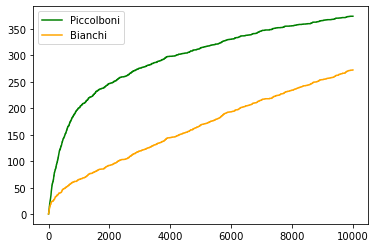

In [55]:
n_cores = 16
horizon = 10000
n_folds = 25


LossMatrix = np.array( [ [0, 1], [1, 0] ] )
FeedbackMatrix =  np.array([ [0, 0],[1, -1] ])

task = SyntheticCase(LossMatrix, FeedbackMatrix, horizon) 
# result = np.cumsum( task.feedexp3( True , 10)  )
# plt.plot(result)

result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, True, 'Piccolboni' ) 
plt.plot(  np.mean( result , 0 ) , label = 'Piccolboni', color = 'green' )

result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, True, 'Bianchi' ) 
plt.plot(  np.mean( result , 0 ) , label = 'Bianchi', color = 'orange' )

plt.legend()

nbCores: 16 nbFolds: 25 Horizon: 10000
nbCores: 16 nbFolds: 25 Horizon: 10000


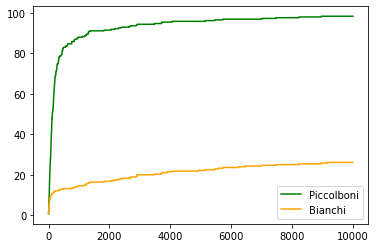

In [ ]:
n_cores = 16
horizon = 10000
n_folds = 25

LossMatrix = np.array( [ [0, 0], [1, -1] ] )
FeedbackMatrix =  np.array([ [0, 0],[1, -1] ])

task = SyntheticCase(LossMatrix, FeedbackMatrix, horizon) 
# result = np.cumsum( task.feedexp3( True , 10)  )
# plt.plot(result)

result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, True, 'Piccolboni' ) 
plt.plot(  np.mean( result , 0 ) , label = 'Piccolboni', color = 'green' )

result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, True, 'Bianchi' ) 
plt.plot(  np.mean( result , 0 ) , label = 'Bianchi', color = 'orange' )

plt.legend()

nbCores: 1 nbFolds: 25 Horizon: 10000
nbCores: 1 nbFolds: 25 Horizon: 10000


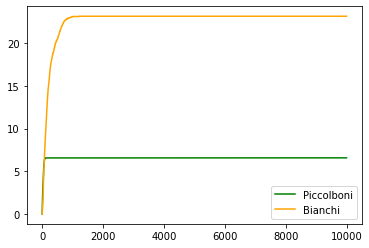

In [113]:
n_cores = 1
horizon = 10000
n_folds = 25

LossMatrix = np.array( [ [1, 1],[0, 1],[1, 0] ] )
FeedbackMatrix = np.array(  [ [1/2, 1], [1/4, 1/4], [1/4, 1/4] ] )

task = SyntheticCase(LossMatrix, FeedbackMatrix, horizon) 

# task.feedexp3(False,'Piccolboni',1)

result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, False, 'Piccolboni' ) 
plt.plot(  np.cumsum( np.mean( result , 0 ) ) , label = 'Piccolboni', color = 'green' )

result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, False, 'Bianchi' ) 
plt.plot(  np.cumsum( np.mean( result , 0 ) ) , label = 'Bianchi', color = 'orange' )

plt.legend()

In [ ]:


# LossMatrix = np.array( [ [1,1,0],[0,1,1],[1,0,1] ] )
# FeedbackMatrix = np.array(  [ [1,0,0], [0,1,0],[0,0,1] ] )
# LinkMatrix = np.linalg.inv( FeedbackMatrix ) @ LossMatrix

# for L_FeedbackMatrix, R_FeedbackMatrix, LinkMatrix, title in zip( Loss_FeedbackMatrix, Reward_FeedbackMatrix, LinkMatrices,['Apple Tasting', 'Bandit']):

    # task = SyntheticCase( LossMatrix, L_FeedbackMatrix , None, horizon) 
    # result = np.cumsum(  eval_ucb1_parallel(task, n_cores, n_folds, horizon,'UCB1' ) ,1 )
    # mean = np.mean(  result,0)
    # std = np.std(  result,0)
    # plt.plot( mean, label = 'UCB1' , color = 'purple' )
    # plt.fill_between( range(horizon), mean - std / np.sqrt(n_folds), mean + std / np.sqrt(n_folds), alpha=0.2, color = 'purple') 

    # task = SyntheticCase(LossMatrix, L_FeedbackMatrix, LinkMatrix, horizon) 
    # result = np.cumsum( eval_feedexp_parallel(task, n_cores, n_folds, horizon,'Bianchi' ) , 1 )
    # mean =   np.mean(  result , 0 )
    # std = np.std( result , 0)
    # plt.plot( mean, label = 'Bianchi', color = 'green' )
    # plt.fill_between( range(horizon), mean -  std / np.sqrt(n_folds), mean +  std / np.sqrt(n_folds), alpha=0.2, color = 'green') 

    # plt.xlabel('Iteration')
    # plt.ylabel('Cumulative Regret')
    # plt.ylim( (0, horizon/2) )
    # plt.xlim( (0, horizon) )
    # plt.legend()
    # plt.title('{}'.format(title) )
    # plt.show()
    # plt.clf() 
    # plt.savefig('baselines_ap.pdf', bbox_inches='tight')
    

nbCores: 16 nbFolds: 15 Horizon: 1000


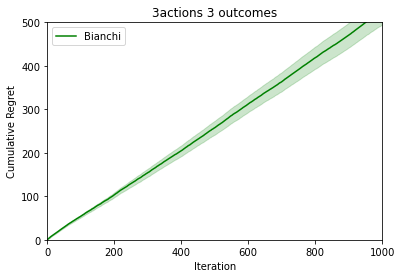

<Figure size 432x288 with 0 Axes>

In [ ]:
n_cores = 16
horizon = 1000
n_folds = 15


LossMatrix = np.array( [ [1,1,0],[0,1,1],[1,0,1] ] )
FeedbackMatrix = np.array(  [ [1,0,0], [0,1,0],[0,0,1] ] )
LinkMatrix = np.linalg.inv( FeedbackMatrix ) @ LossMatrix

# task = SyntheticCase( LossMatrix, FeedbackMatrix , None, horizon) 
# result = np.cumsum(  eval_ucb1_parallel(task, n_cores, n_folds, horizon,'UCB1' ) ,1 )
# mean = np.mean(  result,0)
# std = np.std(  result,0)
# plt.plot( mean, label = 'UCB1' , color = 'purple' )
# plt.fill_between( range(horizon), mean - std / np.sqrt(n_folds), mean + std / np.sqrt(n_folds), alpha=0.2, color = 'purple') 

task = SyntheticCase(LossMatrix, FeedbackMatrix, LinkMatrix, horizon) 
result = np.cumsum( eval_feedexp_parallel(task, n_cores, n_folds, horizon,'Bianchi' ) , 1 )
mean =   np.mean(  result , 0 )
std = np.std( result , 0)
plt.plot( mean, label = 'Bianchi', color = 'green' )
plt.fill_between( range(horizon), mean -  std / np.sqrt(n_folds), mean +  std / np.sqrt(n_folds), alpha=0.2, color = 'green') 

plt.xlabel('Iteration')
plt.ylabel('Cumulative Regret')
plt.ylim( (0, horizon/2) )
plt.xlim( (0, horizon) )
plt.legend()
plt.title('{}'.format('3actions 3 outcomes') )
plt.show()
plt.clf() 

In [ ]:
import ppl
M = 2
p = [ppl.Variable(j) for j in range(M)]
    
# declare polytope constraints
cs = ppl.Constraint_System()
    
# probabilies constraints on p
cs.insert( sum( p[j] for j in range(M)) == 1 )
for j in range(M):
    cs.insert(p[j] >= 0)

cs.insert(p[0] - p[1] <= 0)   
cs.insert(p[1] - p[0] <= 0)   

poly = ppl.C_Polyhedron(cs)

poly.minimized_generators()

Generator_System {point(1/2, 1/2)}